In [30]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [31]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [32]:
df = pd.read_csv("/home/ifte/amiebot_project/MyAI/AI-system/Helpers/processed_dataset.csv")
df['SP_Tok_summ'] = df['Summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [33]:
cnt=0
for i in df['Summary']:
    if(len(i.split())<=12):
        cnt=cnt+1
print(cnt/len(df['Summary']))

cnt=0
for i in df['Article']:
    if(len(i.split())<=250):
        cnt=cnt+1
print(cnt/len(df['Article']))

0.905848787446505
0.8509272467902995


In [34]:
max_text_len=250
max_summary_len=12

In [35]:
series = df.Article.str.split(expand=True).stack().value_counts()
print(series) 

device                                   9013
select                                   3038
email                                    2763
file                                     2679
soti                                     2638
user                                     2396
name                                     2186
mobicontrol                              2029
server                                   2025
enter                                    2024
the                                      1785
rule                                     1643
setting                                  1500
application                              1473
option                                   1436
profile                                  1427
click                                    1419
topic                                    1404
parent                                   1387
use                                      1385
certificate                              1365
list                              

In [234]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
from nltk.tokenize import word_tokenize

frequent_words = ['device', 'click', 'select', 'the', 'to', 'soti']

def preprocess_text(sentence):
    tokenized_words = word_tokenize(sentence)
    tokenized_words = [word for word in tokenized_words if word not in frequent_words]
    return " ".join(tokenized_words)

df.Summary = df.Summary.apply(lambda x: preprocess_text(str(x)))
df.Article = df.Article.apply(lambda x: preprocess_text(str(x)))
df.head()

,Unnamed: 0,Article,Summary,SP_Tok_summ
0,1,help version,banner,_START_ banner _END_
1,3,find page containing match case match whole word use search must enable javascript web browser match case match whole word,search,_START_ search _END_
2,4,mobicontrol help mobicontrol enterprise mobile management solution dedicated helping manage monitor enterprise use mobicontrol help learn feature available mobicontrol a employee increasingly rely...,welcome mobicontrol help start,_START_ welcome soti mobicontrol help start _END_
3,5,mobicontrol this section provides instruction installing activating upgrading mobicontrol instance once installed mobicontrol able manage central system email,setting up mobicontrol setup setupindex,_START_ setting up soti mobicontrol setup setupindex _END_
4,6,mobicontrol each mobicontrol installation consists three component console database deployment server mobicontrol console main interface managing it communicates deployment server exchanging infor...,setting up mobicontrol setup installing installation,_START_ setting up soti mobicontrol setup installing installation _END_


In [37]:
cleaned_text =np.array(df['Article'])
cleaned_summary=np.array(df['Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [38]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [39]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [40]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [41]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 49.51747088186356
Total Coverage of rare words: 3.39120467443876


In [42]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

x_voc

1518

In [43]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [44]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)



% of rare words in vocabulary: 73.65792759051186
Total Coverage of rare words: 9.946619217081851


In [45]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [46]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(1020, 1020)

In [47]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [48]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)


In [49]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

In [50]:
# from tensorflow.keras.models import model_from_json

# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)


In [51]:


# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 250, 100)     151800      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 250, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
# from keras.callbacks import ModelCheckpoint

# # checkpoint
# filepath="weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]


In [52]:
# # load weights
# model.load_weights("weights.best.hdf5")
model.load_weights("/home/ifte/Downloads/trained_weights_seq2seqAtt.hdf5")
# model.load_model("/home/ifte/amiebot_project/MyAI/AI-system/Summarization Models/keras-text-summarization/model.h5")
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [261]:
# history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,callbacks=[es],batch_size=150, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=20,batch_size=150, callbacks=callbacks_list, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 1018 samples, validate on 114 samples
Epoch 1/20
1018/1018 [==============================] - 158s 155ms/sample - loss: 3.1896 - val_loss: 3.0682
Epoch 2/20
1018/1018 [==============================] - 163s 161ms/sample - loss: 3.1401 - val_loss: 2.8479
Epoch 3/20
1018/1018 [==============================] - 160s 157ms/sample - loss: 2.9490 - val_loss: 2.7310
Epoch 4/20
1018/1018 [==============================] - 157s 154ms/sample - loss: 2.8895 - val_loss: 2.6413
Epoch 5/20
1018/1018 [==============================] - 158s 156ms/sample - loss: 2.7544 - val_loss: 2.5471
Epoch 6/20
1018/1018 [==============================] - 162s 159ms/sample - loss: 2.6559 - val_loss: 2.4989
Epoch 7/20
1018/1018 [==============================] - 156s 153ms/sample - loss: 2.5432 - val_loss: 2.3443
Epoch 8/20
1018/1018 [==============================] - 163s 160ms/sample - loss: 2.4636 - val_loss: 2.2769
Epoch 9/20
1018/1018 [==============================] - 149s 147ms/sample - loss: 2.3542 

In [0]:
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

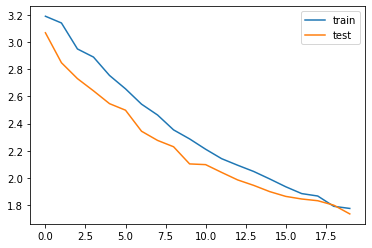

In [264]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [53]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [54]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [55]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [56]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")



Review: you must microsoft azure account set prior configuring connection setting mobicontrol you must also see microsoft azure documentation information following information required mobicontrol azure ldap connection setup metadata document url azure ad api endpoint domain name default set mobicontrol client id application client key application add azure ldap connection mobicontrol on all platform tab server tab under global setting wrench icon beside ldap connection open ldap connection manager dialog box new button azure dropdown list fill field appropriate value manage button configure azure tenant id azure application ok save new ldap connection you enroll window modern using ldap parent topic email 
Original summary: adding azure ldap connection console system ldap adding azure 
Predicted summary:  using content console data


Review: you must perform action configure vpp bb application use application catalog on all platform tab go server tab under global setting wrench icon b

Predicted summary:  using content console data


Review: new custom attribute on all platform tab go server tab under global setting wrench icon beside manage custom attribute in manage custom attribute dialog box add enter name new attribute set data type note once custom attribute saved data type see information if want store attribute value mobicontrol agent enable this option required want use custom attribute option lockdown screen do enable sensitive data ok save new custom attribute you assign value custom attribute system custom attribute type specific parent topic email 
Original summary: creating custom attribute console data customattributes creating 
Predicted summary:  schedule console reference dialog rule alert alert alert


Review: package studio uploaded file general executable file if package studio file executable file automatically executed installing package package studio following file type cab exe xml by default file set autoexecute upon installation parent topi

Predicted summary:  profile console reference dialog profile androidplus profile androidplus


Review: you edit name custom attribute data type edit value custom attribute see edit custom attribute on all platform tab go server tab under global setting wrench icon beside manage custom attribute in manage custom attribute dialog box doubleclick custom attribute want edit activate field enter new name attribute enable disable store attribute value mobicontrol agent this option required want use custom attribute option lockdown screen do enable sensitive data ok rename new custom attribute parent topic email 
Original summary: editing custom attribute console data customattributes editing 
Predicted summary:  using content console data


Review: execution status panel profile tab display various state profile installation targeted profile tip hover pie chart section legend see exact count percentage execution status possible execution status administratively removed describes profile cont

Predicted summary:  setting console reference dialog profile androidplus profile androidplus


Review: status value want trigger alert you specify customized message severity level status event available memory trigger alert based numeric value entered available memory byte available storage trigger alert based numeric value entered available storage byte battery status trigger alert based numeric value entered battery status cellular carrier trigger alert based string value entered cellular carrier ip address trigger alert based string value entered ip address operating system version trigger alert based numeric value entered current system version wifi access point mac address trigger alert based string value entered wifi mac address parent topic email available memory trigger alert based numeric value entered available memory byte available storage trigger alert based numeric value entered available storage byte battery status trigger alert based numeric value entered battery status

Predicted summary:  summary console reference dialog rule alert alert alert


Review: mobicontrol review plan upgrade process note a it change recommends test product upgrade environment if already practice place upgrade upgrade installation mobicontrol back mobicontrol database while mobicontrol setup wizard automatically back database good practice also back if running microsoft sql server back database using tool provided microsoft sql server enterprise manager you also use thirdparty back utility shut current mobicontrol deployment server close mobicontrol console download mobicontrol installer move installer computer want upgrade mobicontrol see information installer need download upgrade run mobicontrol installer administrator launch mobicontrol setup wizard follow instruction setup wizard warning when selecting feature upgrade deselect feature installed previously setup wizard remove feature upgrade once completed wizard automatically upgrade version mobicontrol your warning sig

Predicted summary:  advanced console reference dialog rule datacollection io linux


Review: enter name want assign relocation rule name enter name want assign relocation rule parent topic email name enter name want assign relocation rule email 
Original summary: rule name console reference dialog rule devicerelocation androidplus devicerelocation namecard androidplus 
Predicted summary:  summary console reference dialog rule alert alert alert


Review: display summary information add rule review correctness specify advanced option rule advanced button parent topic email 
Original summary: summary console reference dialog rule adddevice windowsdesktop adddevice summarycard windowsdesktop 
Predicted summary:  summary console reference dialog rule alert alert alert


Review: group data collection rule target when group left pane enrolled group listed right pane deselect individual check box left name parent topic email 
Original summary: rule target console reference dialog rule datacoll

Predicted summary:  setting console reference dialog profile androidplus profile androidplus


Review: you must set enabled use feature see movement open information panel move location tab location tab visible location service available history icon location menu bar movement data collection rule appear map parent topic email 
Original summary: viewing location console monitoring locationservices viewing location 
Predicted summary:  using mobicontrol console managing


Review: use window information protection profile configuration manage access corporate data set restriction application access work data network easily integrated existing data protection policy force use specific application protect data instead general application encrypt data application personal work data parent topic related reference email 
Original summary: window information console configuration profile configuration category restriction 
Predicted summary:  profile console reference dialog profile androidplu

KeyboardInterrupt: 